# MapReduce using SPARK

In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

Populating the interactive namespace from numpy and matplotlib


# Table of Contents

* [SPARK](#SPARK)
    * Installing Spark locally
* [Spark Context](#Spark-Context)
    * [Create A RDD](#Create-A-RDD)
    * [Call `collect` on an RDD: Lazy Spark](#Call-collect-on-an-RDD:-Lazy-Spark)
    * [Operations on RDDs](#Operations-on-RDDs)
    * [Word Examples](#Word-Examples)
    * [Key Value Pairs](#Key-Value-Pairs)
    * [word count 1](#word-count-1)
    * [word count 2:  `reduceByKey()`](#word-count-2:--reduceByKey%28%29)
    * [Nested Syntax](#Nested-Syntax)
    * [Using Cache](#Using-Cache)
    * [Fun with words](#Fun-with-words)
    * [DataFrames](#DataFrames)
    * [Machine Learning](#Machine-Learning)


With shameless stealing of some code and text from:

- https://github.com/tdhopper/rta-pyspark-presentation/blob/master/slides.ipynb
- Databricks and Berkeley Spark MOOC: https://www.edx.org/course/introduction-big-data-apache-spark-uc-berkeleyx-cs100-1x

which you should go check out.

## Installing Spark locally


**Step 1: Install Apache Spark**

For example, for Mac users using Homebrew:

```
$ brew install apache-spark
```

**Step 2: Install the Java SDK version 1.8 or above for your platform (not just the JRE runtime)**

Make sure you can access commands such as `java` on your command line.

**Step 3: Install the latest findspark package using pip**

```
➜  ~  pip install findspark
Collecting findspark
  Downloading findspark-0.0.5-py2.py3-none-any.whl
Installing collected packages: findspark
Successfully installed findspark-0.0.5
```

# Spark Context

You can also use it directly from the notebook interface on the mac if you installed `apache-spark` using `brew` and also installed `findspark` above.

In [2]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext()

It also output's a bunch of stuff on my terminal. This is because the entire java context is started up.

```Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
15/10/21 14:46:15 INFO SparkContext: Running Spark version 1.4.0
2015-10-21 14:46:15.774 java[30685:c003] Unable to load realm info from SCDynamicStore
15/10/21 14:46:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
15/10/21 14:46:15 INFO SecurityManager: Changing view acls to: rahul
15/10/21 14:46:15 INFO SecurityManager: Changing modify acls to: rahul
15/10/21 14:46:15 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users with view permissions: Set(rahul); users with modify permissions: Set(rahul)
15/10/21 14:46:16 INFO Slf4jLogger: Slf4jLogger started
15/10/21 14:46:16 INFO Remoting: Starting remoting
15/10/21 14:46:16 INFO Remoting: Remoting started; listening on addresses :[akka.tcp://sparkDriver@10.251.101.163:64359]
15/10/21 14:46:16 INFO Utils: Successfully started service 'sparkDriver' on port 64359.
15/10/21 14:46:16 INFO SparkEnv: Registering MapOutputTracker
15/10/21 14:46:16 INFO SparkEnv: Registering BlockManagerMaster
15/10/21 14:46:16 INFO DiskBlockManager: Created local directory at /private/var/folders/_f/y76rs29s3c57ykwyz9c8z12c0000gn/T/spark-00a4e09e-e5db-485f-81dc-2e5016e9a27e/blockmgr-8966e07c-223b-4c38-9273-11543aa9d3c1
15/10/21 14:46:16 INFO MemoryStore: MemoryStore started with capacity 273.0 MB
15/10/21 14:46:16 INFO HttpFileServer: HTTP File server directory is /private/var/folders/_f/y76rs29s3c57ykwyz9c8z12c0000gn/T/spark-00a4e09e-e5db-485f-81dc-2e5016e9a27e/httpd-6af0a9e0-1cfe-42c4-a1bd-e01715b98436
15/10/21 14:46:16 INFO HttpServer: Starting HTTP Server
15/10/21 14:46:17 INFO Utils: Successfully started service 'HTTP file server' on port 64360.
15/10/21 14:46:17 INFO SparkEnv: Registering OutputCommitCoordinator
15/10/21 14:46:18 INFO Utils: Successfully started service 'SparkUI' on port 4040.
15/10/21 14:46:18 INFO SparkUI: Started SparkUI at http://10.251.101.163:4040
15/10/21 14:46:18 INFO Executor: Starting executor ID driver on host localhost
15/10/21 14:46:18 INFO Utils: Successfully started service 'org.apache.spark.network.netty.NettyBlockTransferService' on port 64361.
15/10/21 14:46:18 INFO NettyBlockTransferService: Server created on 64361
15/10/21 14:46:18 INFO BlockManagerMaster: Trying to register BlockManager
15/10/21 14:46:18 INFO BlockManagerMasterEndpoint: Registering block manager localhost:64361 with 273.0 MB RAM, BlockManagerId(driver, localhost, 64361)
15/10/21 14:46:18 INFO BlockManagerMaster: Registered BlockManager
```

In [3]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [4]:
sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).map(lambda x: x**2).sum() #Transforms the list into squares then sums result

385

### Create A RDD


In [5]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
# Print out the type of wordsRDD
print type(wordsRDD)

<class 'pyspark.rdd.RDD'>


### Call `collect` on an RDD: Lazy Spark

Spark is lazy. Until you `collect`, nothing is actually run.

>Instead, they just remember the transformations applied to some base dataset (e.g. a file). The transformations are only computed when an action requires a result to be returned to the driver program.

In [6]:
wordsRDD.collect() #Prints out words from the list

['cat', 'elephant', 'rat', 'rat', 'cat']

```
15/10/21 14:59:59 INFO SparkContext: Starting job: collect at <ipython-input-6-dee494da0714>:1
15/10/21 14:59:59 INFO DAGScheduler: Got job 0 (collect at <ipython-input-6-dee494da0714>:1) with 4 output partitions (allowLocal=false)
15/10/21 14:59:59 INFO DAGScheduler: Final stage: ResultStage 0(collect at <ipython-input-6-dee494da0714>:1)
15/10/21 14:59:59 INFO DAGScheduler: Parents of final stage: List()
15/10/21 14:59:59 INFO DAGScheduler: Missing parents: List()
15/10/21 14:59:59 INFO DAGScheduler: Submitting ResultStage 0 (ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:396), which has no missing parents
15/10/21 15:00:00 INFO MemoryStore: ensureFreeSpace(1224) called with curMem=0, maxMem=286300569
15/10/21 15:00:00 INFO MemoryStore: Block broadcast_0 stored as values in memory (estimated size 1224.0 B, free 273.0 MB)
15/10/21 15:00:00 INFO MemoryStore: ensureFreeSpace(777) called with curMem=1224, maxMem=286300569
15/10/21 15:00:00 INFO MemoryStore: Block broadcast_0_piece0 stored as bytes in memory (estimated size 777.0 B, free 273.0 MB)
15/10/21 15:00:00 INFO BlockManagerInfo: Added broadcast_0_piece0 in memory on localhost:64361 (size: 777.0 B, free: 273.0 MB)
15/10/21 15:00:00 INFO SparkContext: Created broadcast 0 from broadcast at DAGScheduler.scala:874
15/10/21 15:00:00 INFO DAGScheduler: Submitting 4 missing tasks from ResultStage 0 (ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:396)
15/10/21 15:00:00 INFO TaskSchedulerImpl: Adding task set 0.0 with 4 tasks
15/10/21 15:00:00 INFO TaskSetManager: Starting task 0.0 in stage 0.0 (TID 0, localhost, PROCESS_LOCAL, 1379 bytes)
15/10/21 15:00:00 INFO TaskSetManager: Starting task 1.0 in stage 0.0 (TID 1, localhost, PROCESS_LOCAL, 1384 bytes)
15/10/21 15:00:00 INFO TaskSetManager: Starting task 2.0 in stage 0.0 (TID 2, localhost, PROCESS_LOCAL, 1379 bytes)
15/10/21 15:00:00 INFO TaskSetManager: Starting task 3.0 in stage 0.0 (TID 3, localhost, PROCESS_LOCAL, 1403 bytes)
15/10/21 15:00:00 INFO Executor: Running task 0.0 in stage 0.0 (TID 0)
15/10/21 15:00:00 INFO Executor: Running task 2.0 in stage 0.0 (TID 2)
15/10/21 15:00:00 INFO Executor: Running task 1.0 in stage 0.0 (TID 1)
15/10/21 15:00:00 INFO Executor: Running task 3.0 in stage 0.0 (TID 3)
15/10/21 15:00:00 INFO Executor: Finished task 1.0 in stage 0.0 (TID 1). 646 bytes result sent to driver
15/10/21 15:00:00 INFO Executor: Finished task 3.0 in stage 0.0 (TID 3). 665 bytes result sent to driver
15/10/21 15:00:00 INFO Executor: Finished task 0.0 in stage 0.0 (TID 0). 641 bytes result sent to driver
15/10/21 15:00:00 INFO Executor: Finished task 2.0 in stage 0.0 (TID 2). 641 bytes result sent to driver
15/10/21 15:00:00 INFO TaskSetManager: Finished task 1.0 in stage 0.0 (TID 1) in 61 ms on localhost (1/4)
15/10/21 15:00:00 INFO TaskSetManager: Finished task 3.0 in stage 0.0 (TID 3) in 60 ms on localhost (2/4)
15/10/21 15:00:00 INFO TaskSetManager: Finished task 0.0 in stage 0.0 (TID 0) in 96 ms on localhost (3/4)
15/10/21 15:00:00 INFO TaskSetManager: Finished task 2.0 in stage 0.0 (TID 2) in 63 ms on localhost (4/4)
15/10/21 15:00:00 INFO DAGScheduler: ResultStage 0 (collect at <ipython-input-6-dee494da0714>:1) finished in 0.120 s
15/10/21 15:00:00 INFO TaskSchedulerImpl: Removed TaskSet 0.0, whose tasks have all completed, from pool
15/10/21 15:00:00 INFO DAGScheduler: Job 0 finished: collect at <ipython-input-6-dee494da0714>:1, took 0.872367 s
```

### Operations on RDDs

From the Spark Programming Guide:

>RDDs support two types of operations: transformations, which create a new dataset from an existing one, and actions, which return a value to the driver program after running a computation on the dataset. For example, map is a transformation that passes each dataset element through a function and returns a new RDD representing the results. On the other hand, reduce is an action that aggregates all the elements of the RDD using some function and returns the final result to the driver program (although there is also a parallel reduceByKey that returns a distributed dataset).

### Word Examples

In [7]:
def makePlural(word):
    return word + 's'

print makePlural('cat') #works with normal words by adding an s to the end, not with for example goose ->  geese

cats


Transform one RDD into another.

In [8]:
pluralRDD = wordsRDD.map(makePlural)
print pluralRDD.first() #Prints 1st word in new list
print pluralRDD.take(2) #Prints 1st 2 words in new list


cats
['cats', 'elephants']


In [9]:
pluralRDD.take(1) #Same as .first() except it returns a list

['cats']

In [10]:
pluralRDD.collect() #All the items in the new list

['cats', 'elephants', 'rats', 'rats', 'cats']

### Key Value Pairs

In [11]:
wordPairs = wordsRDD.map(lambda w: (w, 1)) #Returns a list of tuples with elements and 1
print wordPairs.collect()

[('cat', 1), ('elephant', 1), ('rat', 1), ('rat', 1), ('cat', 1)]


```
➜  sparklect  ps auxwww | grep pyspark
rahul           30685   0.4  0.8  3458120  68712 s012  S+    2:46PM   2:00.21 /System/Library/Java/JavaVirtualMachines/1.6.0.jdk/Contents/Home/bin/java -cp /usr/local/opt/apache-spark/libexec/conf/:/usr/local/opt/apache-spark/libexec/lib/spark-assembly-1.4.0-hadoop2.6.0.jar:/usr/local/opt/apache-spark/libexec/lib/datanucleus-api-jdo-3.2.6.jar:/usr/local/opt/apache-spark/libexec/lib/datanucleus-core-3.2.10.jar:/usr/local/opt/apache-spark/libexec/lib/datanucleus-rdbms-3.2.9.jar -Xms512m -Xmx512m -XX:MaxPermSize=128m org.apache.spark.deploy.SparkSubmit pyspark-shell
rahul           31520   0.0  0.0  2432784    480 s011  R+    6:42PM   0:00.00 grep --color=auto --exclude-dir=.bzr --exclude-dir=.cvs --exclude-dir=.git --exclude-dir=.hg --exclude-dir=.svn pyspark
rahul           31494   0.0  0.7  2548972  57288 s012  S     6:41PM   0:00.10 python -m pyspark.daemon
rahul           31493   0.0  0.7  2548972  57308 s012  S     6:41PM   0:00.10 python -m pyspark.daemon
rahul           31492   0.0  0.7  2548972  57288 s012  S     6:41PM   0:00.11 python -m pyspark.daemon
rahul           31446   0.0  0.8  2548972  68460 s012  S     6:35PM   0:01.34 python -m pyspark.daemon
```

### WORD COUNT!

This little exercise shows how to use mapreduce to calculate the counts of individual words in a list.

In [12]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4) #converts list to RDD with 4 slices


In [13]:
wordCountsCollected = (wordsRDD
                       .map(lambda w: (w, 1))
                       .reduceByKey(lambda x,y: x+y)
                       .collect())

#With reduceByKey the tuples are counted appropriately.

print wordCountsCollected

[('rat', 2), ('elephant', 1), ('cat', 2)]


![Tons of shuffling](https://databricks.gitbooks.io/databricks-spark-knowledge-base/content/images/reduce_by.png)

In [14]:
print (wordsRDD
    .map(lambda w: (w, 1))
    .reduceByKey(lambda x,y: x+y)).toDebugString()

(4) PythonRDD[19] at RDD at PythonRDD.scala:48 []
 |  MapPartitionsRDD[18] at mapPartitions at PythonRDD.scala:427 []
 |  ShuffledRDD[17] at partitionBy at <unknown>:0 []
 +-(4) PairwiseRDD[16] at reduceByKey at <ipython-input-14-c1214cba7909>:3 []
    |  PythonRDD[15] at reduceByKey at <ipython-input-14-c1214cba7909>:3 []
    |  ParallelCollectionRDD[9] at parallelize at PythonRDD.scala:480 []


### Using Cache

In [15]:
wordsList = ['cat', 'elephant', 'rat', 'rat', 'cat']
wordsRDD = sc.parallelize(wordsList, 4)
print wordsRDD
wordsRDD.count()

ParallelCollectionRDD[20] at parallelize at PythonRDD.scala:480


5

Normally, every operation is run from the start. This may be inefficient in many cases. So when appropriate, we may want to cache the result the first time an operation is run on an RDD.

In [16]:
#this is rerun from the start
wordsRDD.count()

5

In [17]:
#default storage level (MEMORY_ONLY)
wordsRDD.cache()#nothing done this is still lazy

ParallelCollectionRDD[20] at parallelize at PythonRDD.scala:480

In [18]:
#parallelize is rerun and cached because we told it to cache
wordsRDD.count()

5

In [19]:
#this `sc.parallelize` is not rerun in this case
wordsRDD.count()

5

Where is this useful: it is when you have branching parts or loops, so that you dont do things again and again. Spark, being "lazy" will rerun the chain again. So `cache` or `persist` serves as a checkpoint, breaking the RDD chain or the *lineage*.

In [20]:
birdsList=['heron','owl']
animList=wordsList+birdsList
animaldict={}

#Assigns value of mammmal to words formerly in wordsList
for e in wordsList:
    animaldict[e]='mammal'

#Assigns value of bird to words formerly in birdsList
for e in birdsList:
    animaldict[e]='bird' 
animaldict

{'cat': 'mammal',
 'elephant': 'mammal',
 'heron': 'bird',
 'owl': 'bird',
 'rat': 'mammal'}

In [21]:
animsrdd = sc.parallelize(animList, 4)
animsrdd.cache()
#below runs the whole chain but causes cache to be populated
mammalcount=animsrdd.filter(lambda w: animaldict[w]=='mammal').count() #
#now only the filter is carried out
birdcount=animsrdd.filter(lambda w: animaldict[w]=='bird').count()
print mammalcount, birdcount

5 2


### Exercises: Fun with MapReduce

Read http://spark.apache.org/docs/latest/programming-guide.html for some useful background and then try out the following exercises

The file `./sparklect/english.stop.txt` contains a list of English stopwords, while the file `./sparklect/shakes/juliuscaesar.txt` contains the entire text of Shakespeare's 'Julius Caesar'.

* Load all of the stopwords into a Python list
* Load the text of Julius Caesar into an RDD using the `sparkcontext.textfile()` method. Call it `juliusrdd`.

In [22]:
# your turn

with open("./sparklect/english.stop.txt") as f:
    stopwords = f.read().splitlines() # splitlines() removes the \n punctuation while reading. 

#76th stopword
print stopwords[75] 

brief


In [23]:
punc = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

#textFile, not textfile
juliusrdd = sc.textFile("./sparklect/shakes/juliuscaesar.txt") 
juliusrdd = juliusrdd.map(lambda x: x.encode('utf-8').lower())
juliusrdd.take(20)

['1599',
 'the tragedy of julius caesar',
 '',
 'by william shakespeare',
 '',
 '',
 '',
 'dramatis personae',
 '',
 '  julius caesar, roman statesman and general',
 "  octavius, triumvir after caesar's death, later augustus caesar,",
 '    first emperor of rome',
 '  mark antony, general and friend of caesar, a triumvir after his',
 'death',
 '  lepidus, third member of the triumvirate',
 '  marcus brutus, leader of the conspiracy against caesar',
 '  cassius, instigator of the conspiracy',
 '  casca,          conspirator against caesar',
 '  trebonius,           "          "     "',
 '  caius ligarius,      "          "     "']

How many words does Julius Caesar have? *Hint: use `flatMap()`*.

In [24]:
# your turn

# def uni_to_clean_str(x):
#     converted = x.encode('utf-8')
#     lowercased_str = converted.lower()
#     # for more difficult cases use re.split(' A|B')
#     lowercased_str = lowercased_str.replace('--',' ')
#     clean_str = lowercased_str.translate(None, punc) #Change 1
#     return clean_str

punc = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

wordcount = juliusrdd.flatMap(lambda x: x.strip(punc).split()).count()
wordcount


21229

Now print the first 20 words of Julius Caesar as a Python list.

In [25]:
# your turn

punc = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~-1234567890'

words = juliusrdd.flatMap(lambda x: x.strip(punc).split())

words.take(20)


['the',
 'tragedy',
 'of',
 'julius',
 'caesar',
 'by',
 'william',
 'shakespeare',
 'dramatis',
 'personae',
 'julius',
 'caesar,',
 'roman',
 'statesman',
 'and',
 'general',
 'octavius,',
 'triumvir',
 'after',
 "caesar's"]

Now print the first 20 words of Julius Caesar, **after removing all the stopwords**. *Hint: use `filter()`*.

In [26]:
# your turn
wordsfilt = words.filter(lambda x: x not in stopwords) #notice words like 'the' and 'of' are not in this list.
wordsfilt.take(20)

['tragedy',
 'julius',
 'caesar',
 'william',
 'shakespeare',
 'dramatis',
 'personae',
 'julius',
 'caesar,',
 'roman',
 'statesman',
 'general',
 'octavius,',
 'triumvir',
 "caesar's",
 'death,',
 'augustus',
 'caesar',
 'emperor',
 'rome']

Now, use the word counting MapReduce code you've seen before. Count the number of times each word occurs and print the top 20 results as a list of tuples of the form `(word, count)`. *Hint: use `takeOrdered()` instead of `take()`*

In [27]:
# your turn
# wordCountsCollected = (wordsRDD
#                        .map(lambda w: (w, 1))
#                        .reduceByKey(lambda x,y: x+y)
#                        .collect())


wordsfilt = words.filter(lambda x: x not in stopwords)
wordsfilt = (wordsfilt
             .map(lambda w: (w, 1))
             .reduceByKey(lambda x,y: x + y)
             )   

wordsfilttop20 = wordsfilt.takeOrdered(20, key = lambda x: -x[1])
wordsfilttop20

[('brutus.', 196),
 ('cassius.', 143),
 ('caesar', 136),
 ('brutus', 111),
 ('thou', 110),
 ('citizen.', 68),
 ('good', 68),
 ('men', 56),
 ('antony.', 54),
 ('thy', 54),
 ('man', 50),
 ('antony', 48),
 ('cassius', 47),
 ('caesar.', 46),
 ('casca.', 42),
 ('thee', 41),
 ("caesar's", 41),
 ('brutus,', 40),
 ('enter', 40),
 ('hear', 35)]

Plot a bar graph. For each of the top 20 words on the X axis, represent the count on the Y axis.

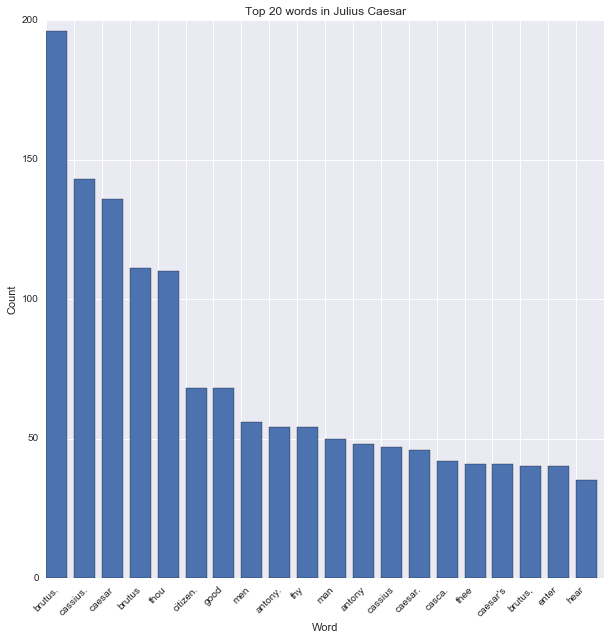

In [28]:
# your turn

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


x,y = [list(c) for c in zip(*wordsfilttop20)]




y_pos = np.arange(len(x))

plt.figure(num=None, figsize=(16, 9), dpi=80, facecolor='w', edgecolor='k')
plt.figure(figsize=(10,10))
plt.bar(y_pos, y, align='edge', width = 0.75)
plt.xticks(y_pos, x, rotation = 45)
plt.ylabel('Count')
plt.xlabel('Word')
plt.title('Top 20 words in Julius Caesar')
plt.show()

### Using partitions for parallelization

In order to make your code more efficient, you want to use all of the available processing power, even on a single laptop. If your machine has multiple cores, you can tune the number of partitions to use all of them! From http://www.stat.berkeley.edu/scf/paciorek-spark-2014.html:

>You want each partition to be able to fit in the memory availalbe on a node, and if you have multi-core nodes, you want that as many partitions as there are cores be able to fit in memory.

>For load-balancing you'll want at least as many partitions as total computational cores in your cluster and probably rather more partitions. The Spark documentation suggests 2-4 partitions (which they also seem to call slices) per CPU. Often there are 100-10,000 partitions. Another rule of thumb is that tasks should take at least 100 ms. If less than that, you may want to repartition to have fewer partitions.

In [29]:
shakesrdd=sc.textFile("./sparklect/shakes/*.txt", minPartitions=4)

In [30]:
shakesrdd.take(10)

[u'1601',
 u'AS YOU LIKE IT',
 u'',
 u'by William Shakespeare',
 u'',
 u'',
 u'',
 u'DRAMATIS PERSONAE.',
 u'',
 u'']

Now calculate the top 20 words in all of the files that you just read.

In [31]:
# your turn
shakesrdd = shakesrdd.map(lambda x: x.encode('utf-8').lower()) 
words2 = shakesrdd.flatMap(lambda x: x.strip(punc).split())
# words2.take(10)

wordsmaster = words + words2 #Adding RDDs to each other 
# wordsmaster.take(20)

wordsfiltplus = wordsmaster.filter(lambda x: x not in stopwords)
# wordsfiltplus.take(20)

wordsfiltplus = (wordsfiltplus
             .map(lambda w: (w, 1))
             .reduceByKey(lambda x,y: x + y)
             )   



wordsfilttop20plus = wordsfiltplus.takeOrdered(20, key = lambda x: -x[1])
wordsfilttop20plus

[('thou', 2143),
 ('thy', 1601),
 ('good', 1211),
 ('thee', 992),
 ('enter', 903),
 ('hath', 815),
 ('love', 796),
 ('make', 674),
 ('lord', 657),
 ('man', 648),
 ('you,', 630),
 ('give', 600),
 ('sir', 594),
 ('sir,', 555),
 ("'tis", 542),
 ('king', 537),
 ('o,', 508),
 ('speak', 472),
 ('exeunt', 451),
 ('me,', 436)]

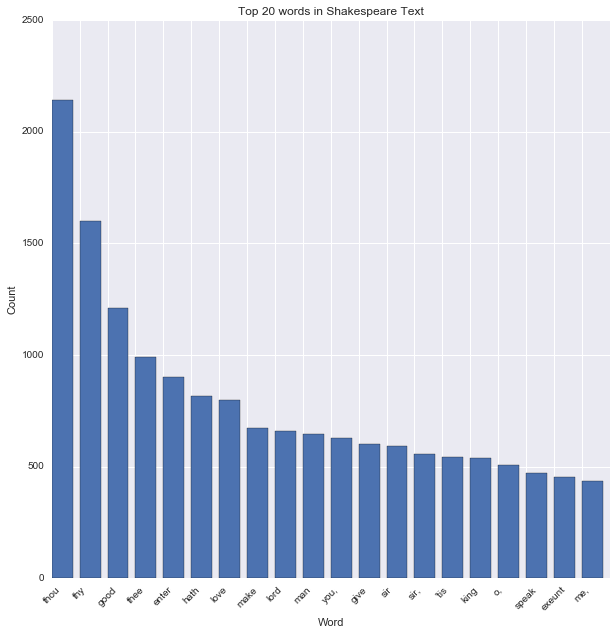

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


x,y = [list(c) for c in zip(*wordsfilttop20plus)]


y_pos = np.arange(len(x))

plt.figure(num=None, figsize=(16, 9), dpi=80, facecolor='w', edgecolor='k')
plt.figure(figsize=(10,10))
plt.bar(y_pos, y, align='edge', width = 0.75)
plt.xticks(y_pos, x, rotation = 45)
plt.ylabel('Count')
plt.xlabel('Word')
plt.title('Top 20 words in Shakespeare Text')
plt.show()